<a href="https://colab.research.google.com/github/rosshalpin/EngineeringProject/blob/main/EngineeringProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/EngProjV2/

/
Mounted at /content/gdrive
/content/gdrive/My Drive/EngProjV2


In [ ]:
!pip install opencv-contrib-python --upgrade

     |████████████████████████████████| 66.7 MB 26 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
%cd /mydrive/EngProjV2/

/content/gdrive/My Drive/EngProjV2


In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
Conf_threshold = 0.8
NMS_threshold = 0.05
COLORS = [(0, 255, 0)]

class_name = ["cereal"]
net = cv2.dnn.readNet('/mydrive/EngProjV2/yolov4.weights', '/mydrive/EngProjV2/yolov4.cfg')
model = cv2.dnn_DetectionModel(net)
model.setInputParams(size=(416, 416), scale=1/255, swapRB=True)

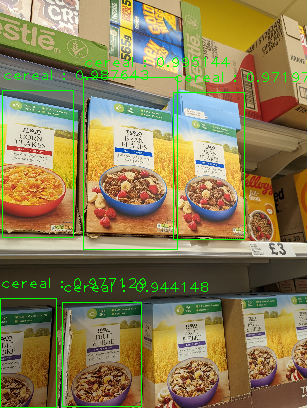

In [ ]:
orig_frame = cv2.imread("test.png")


O_WIDTH = orig_frame.shape[0]
O_HEIGHT = orig_frame.shape[1]


frame = cv2.resize(orig_frame, [int(O_HEIGHT*.1),int(O_WIDTH*.1)], interpolation= cv2.INTER_LINEAR)

WIDTH = frame.shape[0]
HEIGHT = frame.shape[1]

classes, scores, boxes = model.detect(frame, Conf_threshold, NMS_threshold)

new_frame = frame.copy()
for (classid, score, box) in zip(classes, scores, boxes):
  # if list(box) == list(nearest_box["box"]):
  # print(box)
  color = COLORS[int(classid) % len(COLORS)]
  label = "%s : %f" % (class_name[0], score)
  cv2.rectangle(new_frame, box, color, 1)
  cv2.putText(new_frame, label, (box[0], box[1]-10),
              cv2.FONT_HERSHEY_PLAIN, 1, color, 1)
  # cv2.imwrite("object-detection.jpg", frame)
cv2_imshow(new_frame)

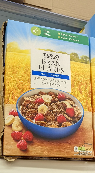

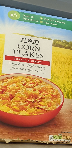

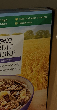

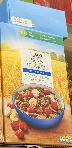

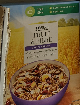

In [ ]:
for box in boxes:
  x = box[0]
  y = box[1]
  w = box[2]
  h = box[3]
  cv2_imshow(frame[y:y+h,x:x+w])

In [ ]:
# from scipy.spatial import distance

# center_x = WIDTH/2
# center_y = HEIGHT/2


# nearest_box = {
#   "dist": 10000000
# }

# for box in boxes:

#   a = (center_y, center_x)
#   b = (box[1], box[0])

#   new_dist = distance.euclidean(b, a)
#   # print(new_dist)
#   if new_dist < nearest_box["dist"]:
#     nearest_box["dist"] = new_dist
#     nearest_box["box"] = box


# print(nearest_box)

{'dist': 68.8712567040852, 'box': array([173,  92,  72, 148], dtype=int32)}


In [ ]:
def knn(img1,images):
    img = cv2.imread(img1)
    imgg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


    surf = cv2.SURF(128)                                                        # SURF keypoint extraction
    kp = surf.detect(imgg)
    kp, descritors = surf.compute(imgg,kp)
    # surf = cv2.SURF(1024)

    samples = np.array(descritors)                                              # Setting up samples and responses for kNN
    responses = np.arange(len(kp),dtype = np.float32)

    knn = cv2.KNearest()                                                          # kNN training
    knn.train(samples,responses)

    # modelImages = ["main1.jpg", "main2.jpg","man1.png"]#, "grup4.jpg"]
    modelImages = images[:]

    for modelImage in modelImages:

        template = cv2.imread(modelImage)                                       # loading a template image and searching for similar keypoints
        templateg= cv2.cvtColor(template,cv2.COLOR_BGR2GRAY)
        keys = surf.detect(templateg)

        keys,desc = surf.compute(templateg, keys)
        count = 0
        lent = len(desc)

        for h,des in enumerate(desc):
            # print h#,des                                                        #debug 
            # print des.shape
            des = des.astype(np.float32).reshape((-1,128))

            retval, results, neigh_resp, dists = knn.find_nearest(des,1)
            res,dist =  int(results[0][0]),dists[0][0]
            print(res, dist)

In [ ]:
import numpy as np
import cv2 as cv

MIN_MATCH_COUNT = 10
img1 = cv.imread('reeses.jpg', 0)  # queryImage
img2 = cv.imread('cereal-aisle.jpg', 0)  # trainImage
# Initiate SIFT detector
sift = cv.xfeatures2d.SIFT_create()
# find the key points and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

In [ ]:
good = []
for m, n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
        h, w = img1.shape
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv.perspectiveTransform(pts, M)
        # img2 = cv.polylines(img2, [np.int32(dst)], True, 255, 3, cv.LINE_AA)

draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   matchesMask=matchesMask,  # draw only in-liers
                   flags=2)

In [ ]:
img3 = cv.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

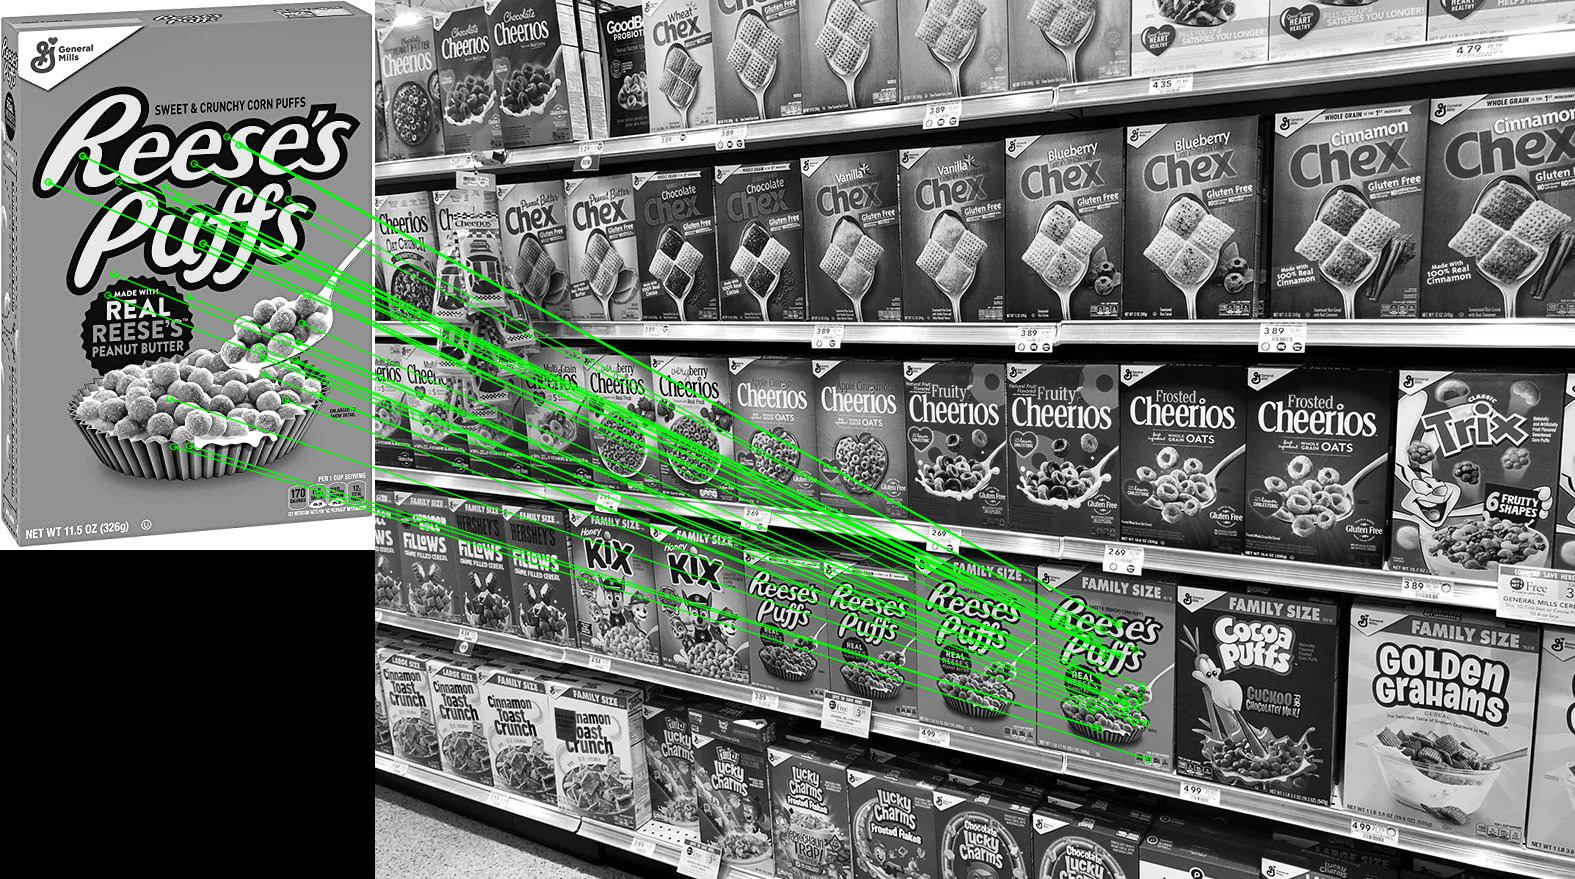

In [ ]:
cv2_imshow(img3)